In [1]:
import numpy as np
import pandas as pd
from os import listdir, rename

from os.path import isfile, join

In [2]:
PATH = 'files/'
files = [f for f in listdir(PATH) if isfile(join(PATH, f))]
for file_name in files:
    rename(PATH+file_name, PATH+file_name.capitalize()) 
files = [f.capitalize() for f in files]
files

['Структура денежных доходов по источникам формирования.xls',
 'Показатели преступности 2017.xlsx',
 'Число выбывших.xls',
 'Общая численность безработных в соответствии с методологией мот.xls',
 'Численность населения с денежными доходами 2010.xlsx',
 'Среднедушевые денежные доходы населения 2017.xlsx',
 'Уровень безработицы (по методологии мот).xls',
 'Показатели преступности 2010.xlsx',
 'Численность постоянного населения - мужчин.xls',
 'Численность постоянного населения - женщин.xls',
 'Величина прожиточного минимума.xls',
 'Численность студентов государственных и муниципальных образовательных 2010.xlsx',
 'Численность студентов государственных и муниципальных образовательных 2017.xlsx',
 'Объем средств, предусмотренных на предоставление социальной поддержки по оплате жилого помещения и коммунальных услуг.xls',
 'Численность граждан, пользующихся социальной поддержкой по оплате жилья и коммунальных услуг.xls',
 'Доля городского населения.xls',
 'Среднедушевые денежные доходы насел

# Данные собраны с разных источников, предобработаем их и приведем к одному формату.

In [3]:
categories = ['perfect', 'two_step', 'grouped']
# 'perfect' - Хорошие готовые данные
#'two_step' - Данные собраные до 2010 и после в разных файлах
# 'grouped' - Данные, внутри которых есть признак группы

file_category = {file : categories[0] for file in files}

two_steps_files = [f.capitalize() for f in  
    ['ЧИСЛЕННОСТЬ СТУДЕНТОВ ГОСУДАРСТВЕННЫХ И МУНИЦИПАЛЬНЫХ ОБРАЗОВАТЕЛЬНЫХ 2010.xlsx', 'ЧИСЛЕННОСТЬ СТУДЕНТОВ ГОСУДАРСТВЕННЫХ И МУНИЦИПАЛЬНЫХ ОБРАЗОВАТЕЛЬНЫХ 2017.xlsx', 'ЧИСЛЕННОСТЬ НАСЕЛЕНИЯ С ДЕНЕЖНЫМИ ДОХОДАМИ 2010.xlsx','Показатели преступности 2017.xlsx','ЧИСЛЕННОСТЬ НАСЕЛЕНИЯ С ДЕНЕЖНЫМИ ДОХОДАМИ 2017.xlsx','СРЕДНЕДУШЕВЫЕ ДЕНЕЖНЫЕ ДОХОДЫ НАСЕЛЕНИЯ 2010.xlsx','СРЕДНЕДУШЕВЫЕ ДЕНЕЖНЫЕ ДОХОДЫ НАСЕЛЕНИЯ 2017.xlsx','Показатели преступности 2010.xlsx'] 
                  ]
file_category.update({file : categories[1] for file in two_steps_files})

grouped_files =  [f.capitalize() for f in  
    ['Структура денежных доходов по источникам формирования.xls', 'Число выбывших.xls']
                 ]
file_category.update({file : categories[2] for file in grouped_files})

file_category

{'Структура денежных доходов по источникам формирования.xls': 'grouped',
 'Показатели преступности 2017.xlsx': 'two_step',
 'Число выбывших.xls': 'grouped',
 'Общая численность безработных в соответствии с методологией мот.xls': 'perfect',
 'Численность населения с денежными доходами 2010.xlsx': 'two_step',
 'Среднедушевые денежные доходы населения 2017.xlsx': 'two_step',
 'Уровень безработицы (по методологии мот).xls': 'perfect',
 'Показатели преступности 2010.xlsx': 'two_step',
 'Численность постоянного населения - мужчин.xls': 'perfect',
 'Численность постоянного населения - женщин.xls': 'perfect',
 'Величина прожиточного минимума.xls': 'perfect',
 'Численность студентов государственных и муниципальных образовательных 2010.xlsx': 'two_step',
 'Численность студентов государственных и муниципальных образовательных 2017.xlsx': 'two_step',
 'Объем средств, предусмотренных на предоставление социальной поддержки по оплате жилого помещения и коммунальных услуг.xls': 'perfect',
 'Численност

In [4]:
def convert_dfs_to_feature(file_name): # Приводим данные в общий формат
    # Сейчас каждый файл - таблица Регион - Год, переведем Регион и Год в признаки
    
    pd_file = pd.read_excel(PATH+file_name)
    id_var_columns = [pd_file.columns[0]]
    
    if file_category[file_name]=='grouped': # Доп колонка для группы
        id_var_columns.append(pd_file.columns[1])
        
    value_columns_name = file_name.split('.')[0]
    
    transformed_pd_file = pd.melt(pd_file, id_vars=id_var_columns, var_name='Year', value_name=value_columns_name).rename(columns = {id_var_columns[0] : 'Region'})

    transformed_pd_file['Region'] = [region.replace('\n', ' ').strip() for region in transformed_pd_file['Region'].tolist()]
    try:
        transformed_pd_file['Year'] = [int(year[:4]) for year in transformed_pd_file['Year']]
    except:
        pass
    
    transformed_pd_file['Year']=transformed_pd_file['Year'].astype('float64')
    
    if file_category[file_name]=='grouped': # Обработаем данные с группами
        transformed_pd_file = preproc_grouped(transformed_pd_file, file_name)

    return transformed_pd_file

In [5]:
def preproc_grouped(transformed_pd_file, file_name):
# Предобратываем данные с признаком группы
    groups = transformed_pd_file['Unnamed: 1'].unique()
    file_name_columns = file_name.split('.')[0]
    for group in groups: # мерджим группы по ключу регион-год
        pd_file_group = transformed_pd_file[transformed_pd_file['Unnamed: 1']==group]
        pd_file_group = pd_file_group.rename(columns={file_name_columns:file_name_columns+' '+group})
        pd_file_group = pd_file_group.drop('Unnamed: 1', axis=1)
        try:
            full_group = pd.merge(pd_file_group, full_group, how='outer', on=['Region', 'Year'])
        except:
            full_group = pd_file_group
    return full_group

In [6]:
def preproc_two_step(file_name):
# Обрабатываем данные из двух файлов
    file_name_part = file_name.split(' 20')[0]
    file_name1, file_name2 = [s for s in files if file_name_part in s]
    
    pd_file1 = pd.read_excel(PATH+file_name1)
    pd_file2 = pd.read_excel(PATH+file_name2)
    
    transformed_pd_file1 = convert_dfs_to_feature(file_name1)
    transformed_pd_file2 = convert_dfs_to_feature(file_name2)
    # мерджим оба файла по ключу регион-год
    transformed_pd_file = pd.merge(transformed_pd_file1, transformed_pd_file2, how='outer', on=['Region', 'Year'])
    # Заполняем пропуски в '2017' данными из '2010', чтобы получить полные данные
    transformed_pd_file[file_name_part] = transformed_pd_file[file_name_part+' 2017'].combine_first(transformed_pd_file[file_name_part+' 2010'])
    
    transformed_pd_file = transformed_pd_file.drop([file_name_part+' 2017', file_name_part+' 2010'], axis=1)
    
    return transformed_pd_file, file_name1, file_name2

In [7]:
final_pd, file_name1, file_name2 = preproc_two_step('Показатели преступности 2010.xlsx')
already_processed = [file_name1, file_name2]
# Обрабатываем все файлы
for file_name in files:
    if file_name not in already_processed:
        
        if file_category[file_name]=='two_step':
            transformed_pd_file, file_name1, file_name2 = preproc_two_step(file_name)
            already_processed.extend([file_name1, file_name2])
            
        else:
            transformed_pd_file = convert_dfs_to_feature(file_name)
            
        final_pd = pd.merge(transformed_pd_file, final_pd, how='right', on=['Region', 'Year'])

In [8]:
import matplotlib.pyplot as plt

# Данные собраны с разных источников, поэтому имеются пропуски. Посмотрим гистограмму пропусков в строках.

(array([569., 556.,  82.,   9.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,  60.,  76.,   6., 157.,  66.,  63.,  76.,  71.]),
 array([ 0.  ,  0.95,  1.9 ,  2.85,  3.8 ,  4.75,  5.7 ,  6.65,  7.6 ,
         8.55,  9.5 , 10.45, 11.4 , 12.35, 13.3 , 14.25, 15.2 , 16.15,
        17.1 , 18.05, 19.  ]),
 <a list of 20 Patch objects>)

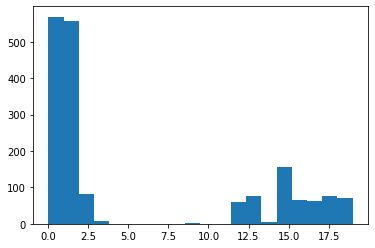

In [9]:
plt.hist(final_pd.isnull().sum(axis=1), bins=20)

# Выберем данные, в которых до 3 пропусков.

In [10]:
indexes_to_save = final_pd.isnull().sum(axis=1)[final_pd.isnull().sum(axis=1)<3].index
data = final_pd.loc[indexes_to_save]
data

,Region,Year,Уровень занятости,Доля городского населения,"Численность граждан, пользующихся социальной поддержкой по оплате жилья и коммунальных услуг","Объем средств, предусмотренных на предоставление социальной поддержки по оплате жилого помещения и коммунальных услуг",Численность студентов государственных и муниципальных образовательных,Величина прожиточного минимума,Численность постоянного населения - женщин,Численность постоянного населения - мужчин,...,Среднедушевые денежные доходы населения,Численность населения с денежными доходами,Общая численность безработных в соответствии с методологией мот,Число выбывших Международная,Число выбывших Всего,Число выбывших В пределах России,Структура денежных доходов по источникам формирования Социальные трансферты,Структура денежных доходов по источникам формирования Оплата труда,Структура денежных доходов по источникам формирования Другие доходы,Показатели преступности
0,Российская Федерация,2000.0,58.5,73.13,46015.0,17548.0,158,1138.0,78191844.0,68698284.0,...,2281,29,7699.5,11155.0,176270.0,165115.0,13.8,36.5,27.5,2014
1,Белгородская область,2000.0,61.7,65.06,474.0,229.0,167,NaN,809961.0,691738.0,...,1555,33.6,44.9,172.0,1794.0,1622.0,16.6,40.2,21.3,1323
2,Брянская область,2000.0,54.1,68.39,499.0,120.0,174,NaN,769127.0,654051.0,...,1312,42.3,88.8,153.0,1895.0,1742.0,25.7,32.3,24.1,2107
3,Владимирская область,2000.0,57.6,79.85,514.0,159.0,173,NaN,856789.0,718718.0,...,1280,44.7,95.5,83.0,1632.0,1549.0,21.9,46.3,20.1,2031
4,Воронежская область,2000.0,56.8,61.44,588.0,187.0,179,NaN,1319776.0,1121561.0,...,1487,41.9,118.6,144.0,2306.0,2162.0,17.8,34.2,27.8,1606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,Амурская область,2016.0,63.6,67.30,184.0,2199.2,196,11852.0,NaN,381390.0,...,29653,16.1,24.6,225.0,2026.0,1801.0,21.6,63.6,2.1,2321
1217,Магаданская область,2016.0,73.5,95.50,22.0,418.5,160,17901.0,NaN,70867.0,...,50753,13.3,4.0,39.0,537.0,498.0,17.3,73.3,1.4,2046
1218,Сахалинская область,2016.0,68.6,81.60,102.0,1606.4,152,13807.0,NaN,234124.0,...,49599,9.9,17.6,75.0,1364.0,1289.0,18.2,70.0,1.2,2513
1219,Еврейская автономная область,2016.0,61.4,68.60,41.0,532.6,112,12620.0,NaN,78816.0,...,23718,25.1,6.9,8.0,303.0,295.0,23.8,61.4,4.3,2073


In [11]:
data.count()

Region                                                                                                                   1207
Year                                                                                                                     1207
Уровень занятости                                                                                                        1207
Доля городского населения                                                                                                1207
Численность граждан, пользующихся социальной поддержкой по оплате жилья и коммунальных услуг                             1207
Объем средств, предусмотренных на предоставление социальной поддержки по оплате жилого помещения и коммунальных услуг    1207
Численность студентов государственных и муниципальных образовательных                                                    1074
Величина прожиточного минимума                                                                                        

## Уберем признаки, в которых много пропусков.

In [12]:
data = data.drop(['Величина прожиточного минимума', 'Численность постоянного населения - женщин'], axis=1)

## Часть признаков относительная, часть абсолютная. Приведем все абсолютные признаки численности к показателю количество на 100.000 человек

In [13]:
data['Население'] = 2*data['Численность постоянного населения - мужчин']
data['Относительная Численность граждан с соц поддержкой'] = data['Численность граждан, пользующихся социальной поддержкой по оплате жилья и коммунальных услуг']/data["Население"]*100000
data['Относительный объем социальной поддержки'] = data['Объем средств, предусмотренных на предоставление социальной поддержки по оплате жилого помещения и коммунальных услуг']/data["Население"]*100000
data['Относительное число выбывших В пределах России'] = data['Число выбывших В пределах России']/data["Население"]*100000
data['Относительное число выбывших Международная'] = data['Число выбывших Международная']/data["Население"]*100000
data['Относительное число выбывших Всего'] = data['Число выбывших Всего']/data["Население"]*100000

# Некоторые данные не в числовом формате, обработаем их

In [14]:
for col in data.columns[2:]:
    try:
        data[col] = [x.replace(',', '.') for x in data[col]]
        data[col] = data[col].astype('float64')
    except:
        pass
data['Численность населения с денежными доходами'] = [x if type(x)==float or type(x)==int else np.nan for x in data['Численность населения с денежными доходами'].tolist()]
data['Показатели преступности'] = [x if type(x)==float or type(x)==int else np.nan for x in data['Показатели преступности'].tolist()]


# Остальные пропуски заменим средним

In [15]:
data.fillna((data.mean()), inplace=True)

# Переименуем признаки для более удобного анализа

In [16]:
name_col_tag_dict = dict()
for id_tag, col_name in enumerate(data.columns[2:]):
    if col_name == 'Показатели преступности':
        data = data.rename(columns={col_name:'Y'})
        name_col_tag_dict['Y'] = col_name
        print(col_name + ' : Y')
    else:
        data = data.rename(columns={col_name:'tag_N_'+str(id_tag)})
        name_col_tag_dict['tag_N_'+str(id_tag)] = col_name
        print(col_name + ' : tag_N_'+str(id_tag))


Уровень занятости : tag_N_0
Доля городского населения : tag_N_1
Численность граждан, пользующихся социальной поддержкой по оплате жилья и коммунальных услуг : tag_N_2
Объем средств, предусмотренных на предоставление социальной поддержки по оплате жилого помещения и коммунальных услуг : tag_N_3
Численность студентов государственных и муниципальных образовательных : tag_N_4
Численность постоянного населения - мужчин : tag_N_5
Уровень безработицы (по методологии мот) : tag_N_6
Среднедушевые денежные доходы населения : tag_N_7
Численность населения с денежными доходами : tag_N_8
Общая численность безработных в соответствии с методологией мот : tag_N_9
Число выбывших Международная : tag_N_10
Число выбывших Всего : tag_N_11
Число выбывших В пределах России : tag_N_12
Структура денежных доходов по источникам формирования Социальные трансферты : tag_N_13
Структура денежных доходов по источникам формирования Оплата труда : tag_N_14
Структура денежных доходов по источникам формирования Другие до

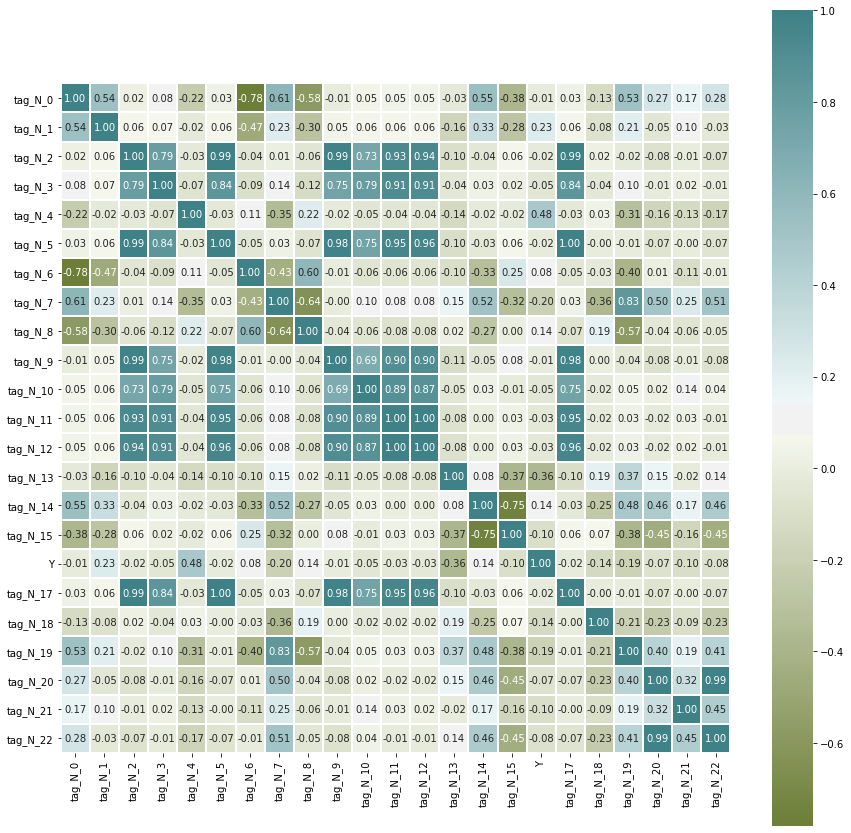

In [17]:
import seaborn as sns
f,ax=plt.subplots(figsize=(15,15))

corr_matrix=data.drop(['Region', 'Year'], axis=1).corr()

sns.heatmap(corr_matrix, annot=True, linewidths=1, fmt='.2f', 
            mask= np.zeros_like(corr_matrix,dtype=np.bool), 
            cmap=sns.diverging_palette(100,200,as_cmap=True), 
            square=True, ax=ax)

plt.show()

# Крайне высокая корреляция (>0.95) между следующими признаками:

In [18]:
threshold = 0.95
col_corr = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (abs(corr_matrix.iloc[i, j]) >= threshold):
            colname = corr_matrix.columns[i]
            print(str(i), name_col_tag_dict[corr_matrix.columns[i]], ' и ', str(j), name_col_tag_dict[corr_matrix.columns[j]])
            col_corr.add(colname)

5 Численность постоянного населения - мужчин  и  2 Численность граждан, пользующихся социальной поддержкой по оплате жилья и коммунальных услуг
9 Общая численность безработных в соответствии с методологией мот  и  2 Численность граждан, пользующихся социальной поддержкой по оплате жилья и коммунальных услуг
9 Общая численность безработных в соответствии с методологией мот  и  5 Численность постоянного населения - мужчин
11 Число выбывших Всего  и  5 Численность постоянного населения - мужчин
12 Число выбывших В пределах России  и  5 Численность постоянного населения - мужчин
12 Число выбывших В пределах России  и  11 Число выбывших Всего
17 Население  и  2 Численность граждан, пользующихся социальной поддержкой по оплате жилья и коммунальных услуг
17 Население  и  5 Численность постоянного населения - мужчин
17 Население  и  9 Общая численность безработных в соответствии с методологией мот
17 Население  и  11 Число выбывших Всего
17 Население  и  12 Число выбывших В пределах России
22 

In [19]:
# Исходя из этих результатов удалим признаки, которые несут меньше информации
for i in [2, 5, 11, 17, 22]:
    del name_col_tag_dict['tag_N_'+ str(i)]
    del data['tag_N_'+ str(i)]

In [20]:
name_col_tag_dict

{'tag_N_0': 'Уровень занятости',
 'tag_N_1': 'Доля городского населения',
 'tag_N_3': 'Объем средств, предусмотренных на предоставление социальной поддержки по оплате жилого помещения и коммунальных услуг',
 'tag_N_4': 'Численность студентов государственных и муниципальных образовательных',
 'tag_N_6': 'Уровень безработицы (по методологии мот)',
 'tag_N_7': 'Среднедушевые денежные доходы населения',
 'tag_N_8': 'Численность населения с денежными доходами',
 'tag_N_9': 'Общая численность безработных в соответствии с методологией мот',
 'tag_N_10': 'Число выбывших Международная',
 'tag_N_12': 'Число выбывших В пределах России',
 'tag_N_13': 'Структура денежных доходов по источникам формирования Социальные трансферты',
 'tag_N_14': 'Структура денежных доходов по источникам формирования Оплата труда',
 'tag_N_15': 'Структура денежных доходов по источникам формирования Другие доходы',
 'Y': 'Показатели преступности',
 'tag_N_18': 'Относительная Численность граждан с соц поддержкой',
 'tag_N

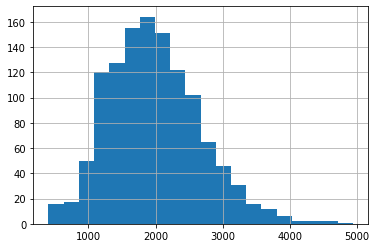

In [21]:
data['Y'].hist(bins=20)

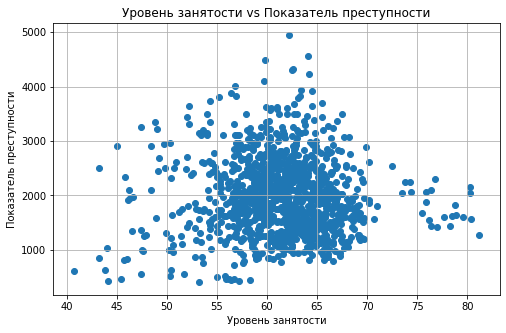

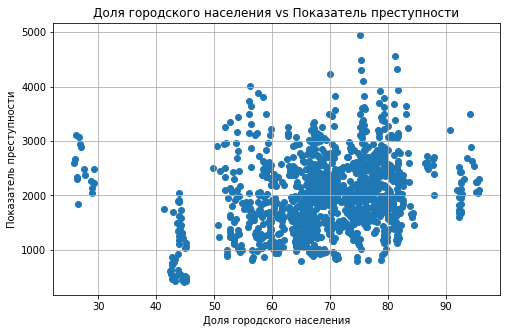

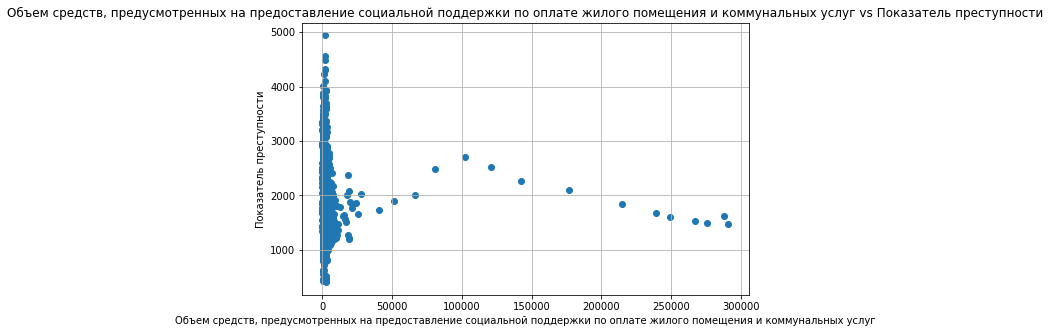

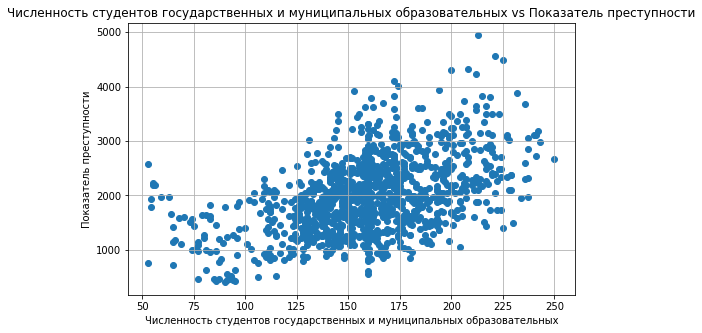

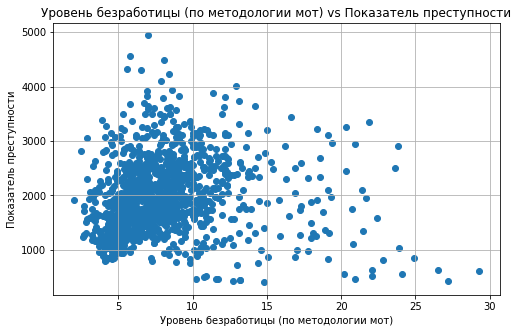

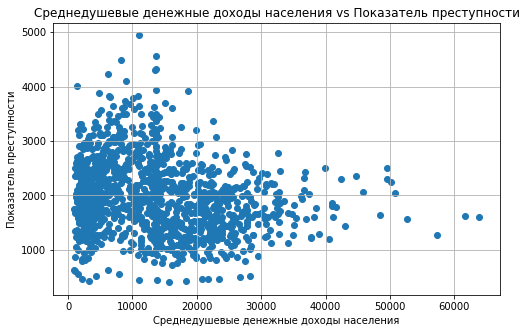

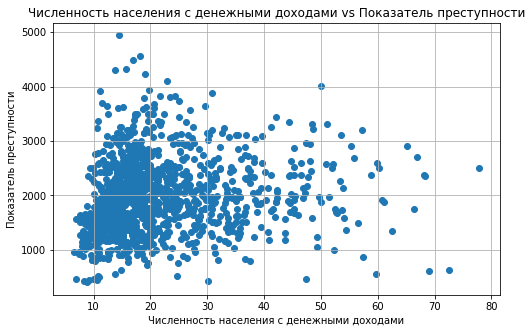

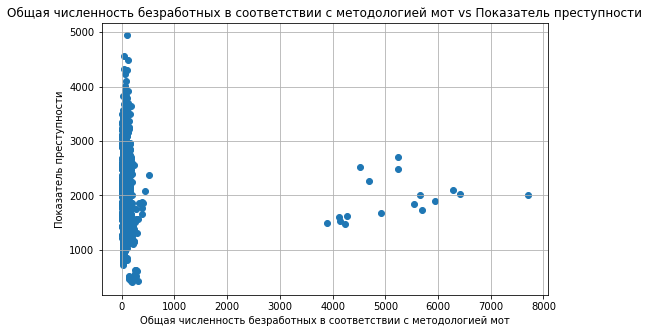

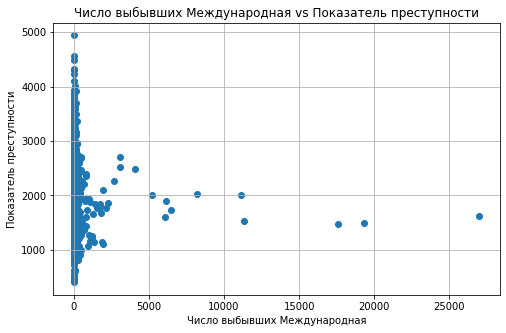

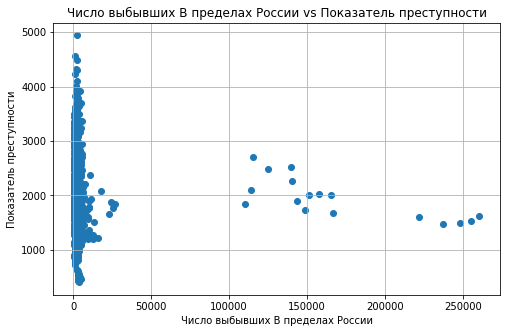

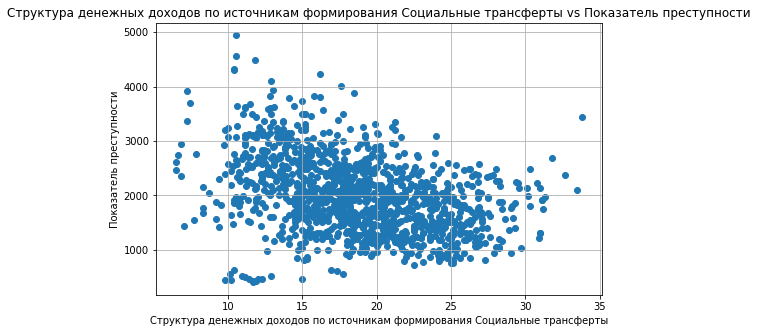

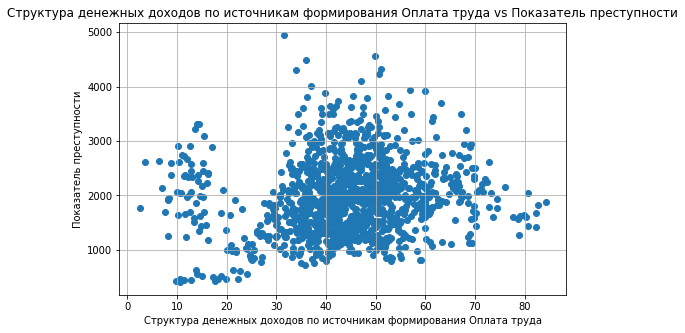

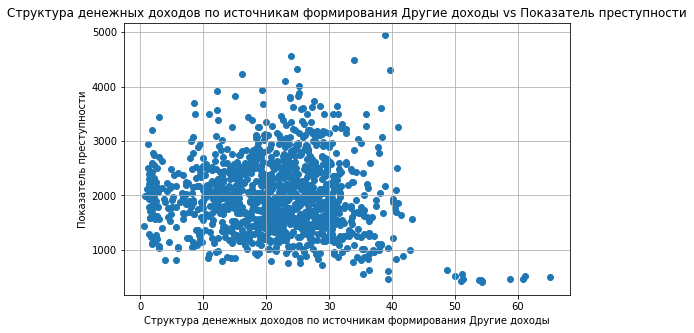

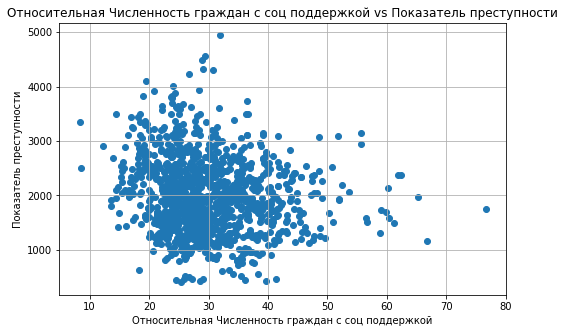

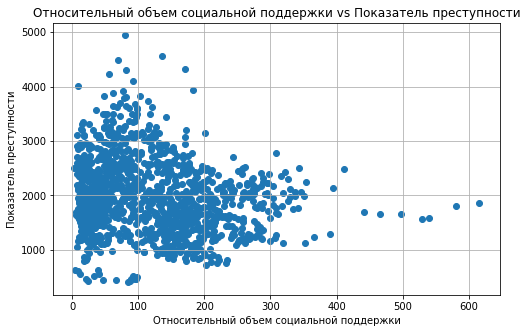

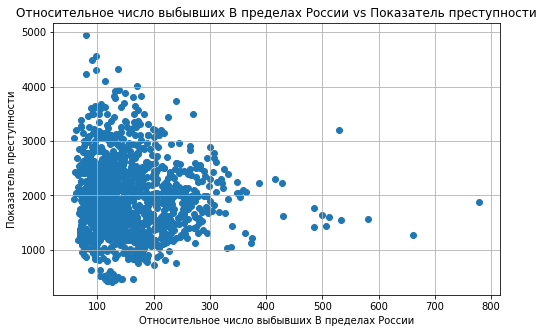

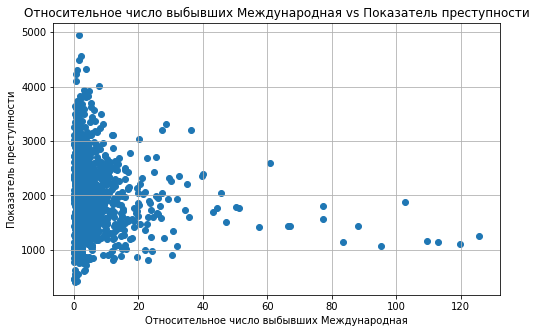

In [22]:

for col_name in data.columns[2:]:
    if col_name!='Y':
        plt.figure(figsize=(8,5))
        plt.title(name_col_tag_dict[col_name]+' vs Показатель преступности')
        plt.scatter(x=data[col_name], y=data['Y'])
        plt.grid(True)
        plt.xlabel(name_col_tag_dict[col_name])
        plt.ylabel('Показатель преступности')
        plt.show()

# Часть признаков стоит отшкалировать

In [23]:
data['tag_N_3'] = np.log(data['tag_N_3']+1)
data['tag_N_8'] = np.log(data['tag_N_8']+1)
data['tag_N_9'] = np.log(data['tag_N_9']+1)
data['tag_N_10'] = np.log(data['tag_N_10']+1)
data['tag_N_12'] = np.log(data['tag_N_12']+1)

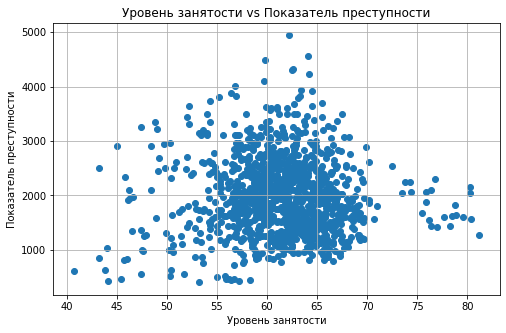

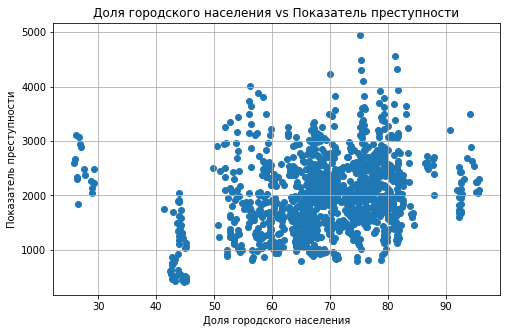

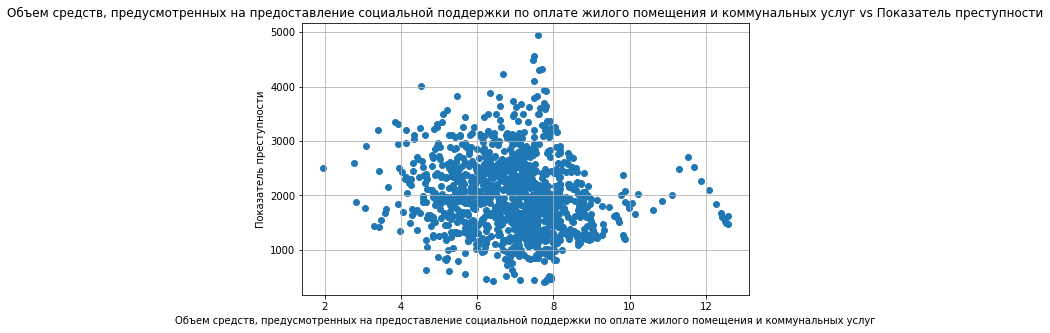

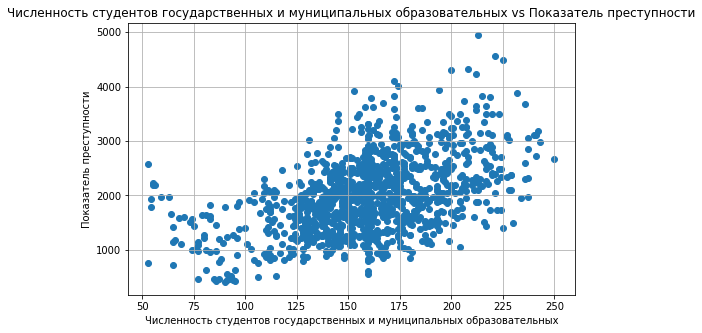

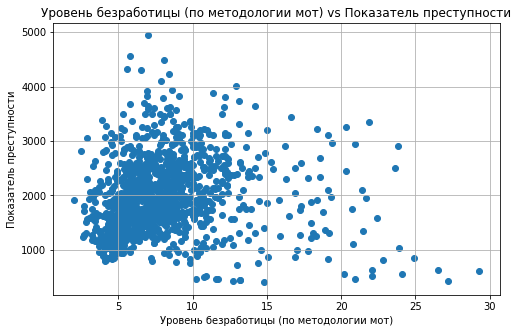

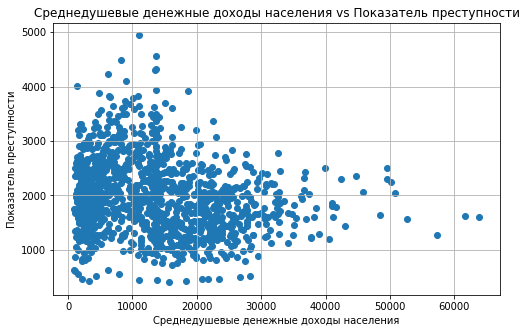

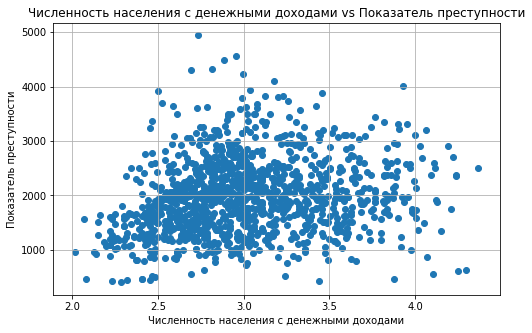

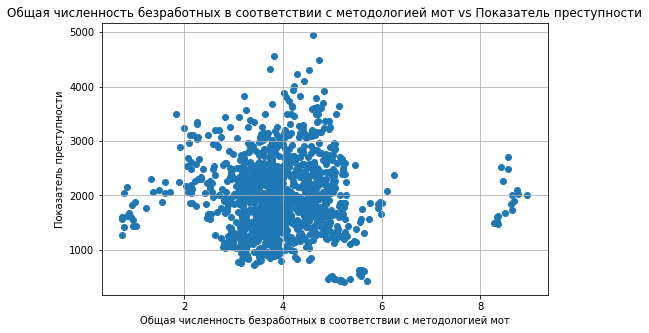

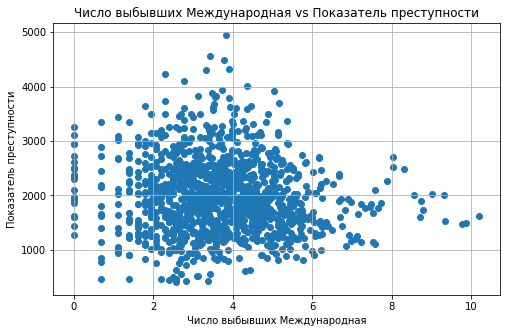

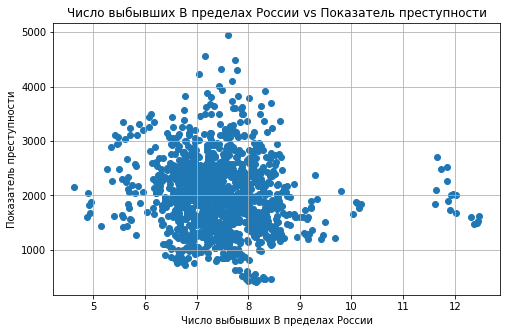

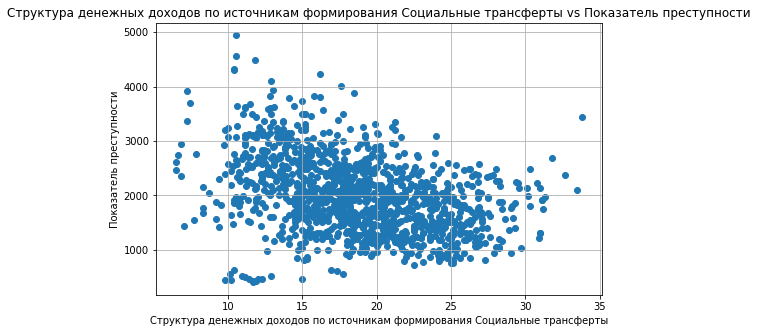

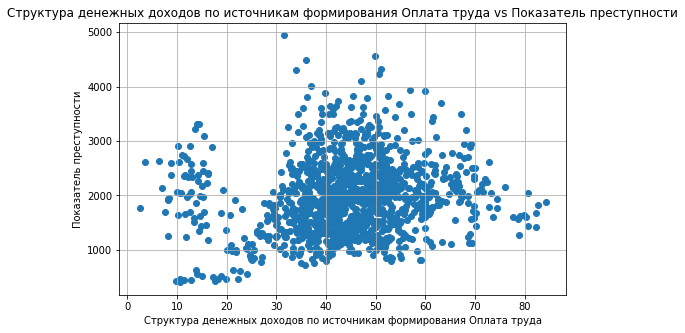

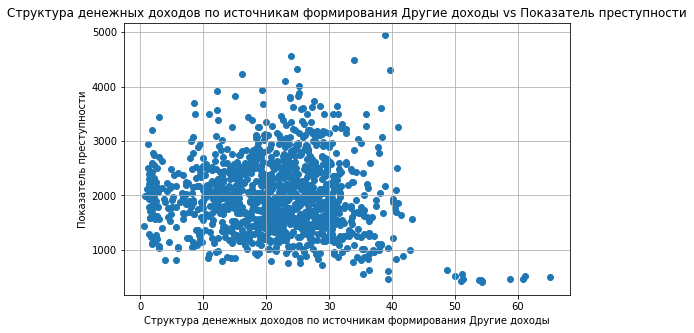

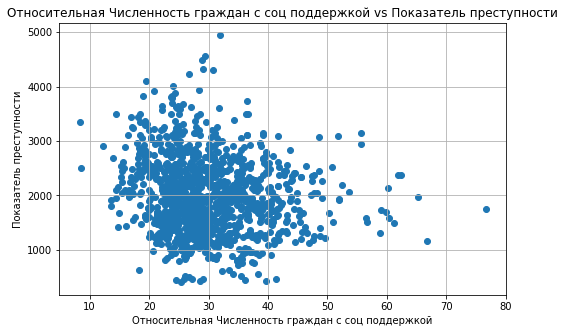

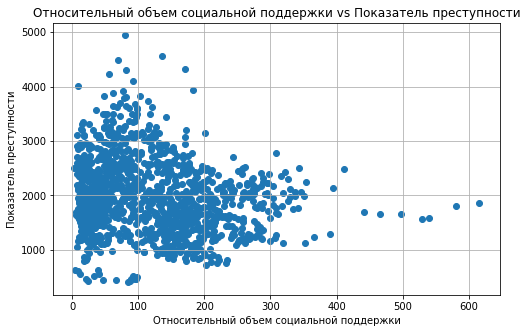

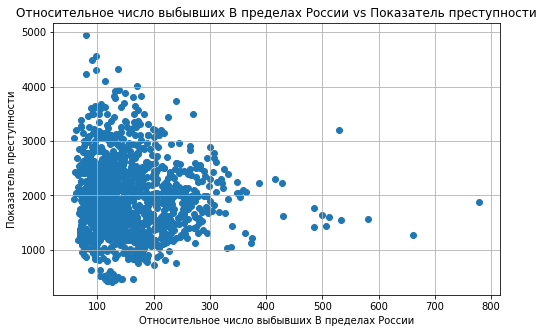

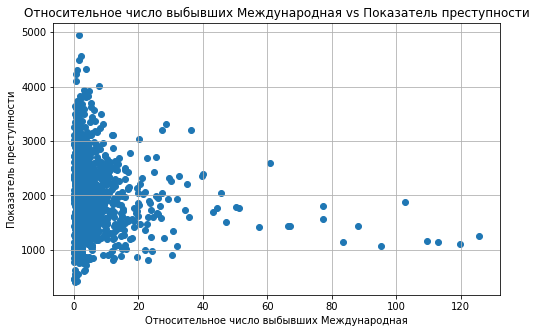

In [24]:

for col_name in data.columns[2:]:
    if col_name!='Y':
        plt.figure(figsize=(8,5))
        plt.title(name_col_tag_dict[col_name]+' vs Показатель преступности')
        plt.scatter(x=data[col_name], y=data['Y'])
        plt.grid(True)
        plt.xlabel(name_col_tag_dict[col_name])
        plt.ylabel('Показатель преступности')
        plt.show()

# Посмотрим попарные графики

In [ ]:
from seaborn import pairplot
pairplot(data.iloc[:, 2:])

# Cудя по графикам явных зависимостей, кроме уровеня безработицы и занятости, незаметно. Однако явно есть выбросы в признаках с абсолютным количеством человек, скорее всего, это Москва в разные годы
# Добавим признак Москвы

In [ ]:
data['IsMoscow']=0
data.loc[data[data['Region']=='Московская область'].index, 'IsMoscow']=1
data_no_Moscow = data[data['IsMoscow']==0]

# BaseLine

# Все собранные данные можно разбить по следующим тэгам.
1) Поддержка граждан:
'Численность граждан, пользующихся социальной поддержкой по оплате жилья и коммунальных услуг',
'Объем средств, предусмотренных на предоставление социальной поддержки по оплате жилого помещения и коммунальных услуг',
'Структура денежных доходов по источникам формирования Социальные трансферты',
'Относительная Численность граждан с соц поддержкой'

2) Образование и занятость:
'Численность студентов государственных и муниципальных образовательных',
'Уровень занятости',
'Уровень безработицы (по методологии МОТ)'

3) Достаток:
'Величина прожиточного минимума',
'Среднедушевые денежные доходы населения',
'Структура денежных доходов по источникам формирования Оплата труда',
'Структура денежных доходов по источникам формирования Другие доходы',
'Численность населения с денежными доходами', (ниже прожиточного минимума)

4) Миграция и демография:
'Доля городского населения',
'Численность постоянного населения - женщин',
'Число выбывших Международная',
'Относительное число выбывших В пределах России',
'Относительное число выбывших Международная'],

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
linear = LinearRegression()

In [ ]:
X = data[['tag_N_8', 'tag_N_9']] # Уровень безработицы (по методологии мот), Среднедушевые денежные доходы населения
Y = data['Y']

In [ ]:
r2_list = []
mse_list = []
mae_list = []
linear = LinearRegression()
coefs = []
for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)
    linear.fit(X_train, Y_train)
    Y_pred = linear.predict(X_test)
    coefs.append(linear.coef_)
    r2_list.append(r2_score(Y_pred, Y_test))
    mse_list.append(mean_squared_error(Y_pred, Y_test))
    mae_list.append(mean_absolute_error(Y_pred, Y_test))
    
print('mse: ', np.mean(mse_list), ' mae: ', np.mean(mae_list))

In [ ]:
plt.scatter(Y_pred, Y_test)
plt.plot([0, 4000],[0, 4000],color='red')
plt.title('Predicted vs. Actual')
plt.ylabel('Predicted')
plt.xlabel('Actual')

# Чуть более подробно:

In [ ]:
import statsmodels.formula.api as sm

formula_str = 'Y ~ '+'+'.join(X.columns)


model=sm.ols(formula=formula_str, data=data)
results = model.fit()
results.summary()

### На уровне значимости 5% tag_N_9 не вносит статистически значимого вклада в прогноз

In [ ]:
df_result=pd.DataFrame()
df_result['pvalues']=results.pvalues[1:]

df_result['Features']=X.columns
df_result.set_index('Features',inplace=True)
def yes_no(b):
    if b<0.05:
        return 'Yes'
    else:
        return 'No'
df_result['Statistically significant?']= df_result['pvalues'].apply(yes_no)
df_result

### Распределение остатков визуально выглядит нормальными

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(results.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

In [ ]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(8,5))
fig=qqplot(results.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

### Модель явно плохо описывает данные

In [ ]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(results.predict(), results.resid); # print resids vs predictions
plt.plot([0, 4000],[0, 0], color='red')
plt.title("Residuals plot from OLS Model")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

In [ ]:
name_col_tag_dict

# На уровне значимости 5% "Общая численность безработных в соответствии с методологией мот" не имеет статистически значимого вклада в "Показатели преступности". Значит теория Беккера не подтверждается на этих данных. Попробуем остальные параметры.

In [ ]:
X = data.drop(['Y', 'Region', 'Year'], axis=1)

In [ ]:
r2_list = []
mse_list = []
mae_list = []
linear = LinearRegression()
linear.fit(X, Y)
coefs = []
for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)
    linear.fit(X_train, Y_train)
    Y_pred = linear.predict(X_test)
    coefs.append(linear.coef_)
    r2_list.append(r2_score(Y_pred, Y_test))
    mse_list.append(mean_squared_error(Y_pred, Y_test))
    mae_list.append(mean_absolute_error(Y_pred, Y_test))
    
print('mse: ', np.mean(mse_list), ' mae: ', np.mean(mae_list))

In [ ]:
import statsmodels.formula.api as sm

formula_str = 'Y ~ '+'+'.join(X.columns)


model=sm.ols(formula=formula_str, data=data)
results = model.fit()
results.summary()

### Метрики модели уже гораздо лучше. Давайте выделим статистически значимые признаки при прогнозе.

In [ ]:
df_result=pd.DataFrame()
df_result['pvalues']=results.pvalues[1:]

df_result['Features']=X.columns
df_result.set_index('Features',inplace=True)
def yes_no(b):
    if b<0.05:
        return 'Yes'
    else:
        return 'No'
df_result['Statistically significant?']= df_result['pvalues'].apply(yes_no)
df_result

In [ ]:
X = X[df_result[df_result['Statistically significant?']=='Yes'].index]

In [ ]:
r2_list = []
mse_list = []
mae_list = []
linear = LinearRegression()
linear.fit(X, Y)
coefs = []
for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)
    linear.fit(X_train, Y_train)
    Y_pred = linear.predict(X_test)
    coefs.append(linear.coef_)
    r2_list.append(r2_score(Y_pred, Y_test))
    mse_list.append(mean_squared_error(Y_pred, Y_test))
    mae_list.append(mean_absolute_error(Y_pred, Y_test))
    
print('mse: ', np.mean(mse_list), ' mae: ', np.mean(mae_list))

In [ ]:
import statsmodels.formula.api as sm

formula_str = 'Y ~ '+'+'.join(X.columns)


model=sm.ols(formula=formula_str, data=data)
results = model.fit()
results.summary()

### Нас предупреждают о мультиколлинеарности, однако корреляция признаков достаточно мала.

In [ ]:
X.corr()

### Остатки визуально выглядят нормальными

In [ ]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(8,5))
fig=qqplot(results.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(results.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

In [ ]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(results.predict(), results.resid); # print resids vs predictions
plt.plot([0, 4000],[0, 0], color='red')
plt.title("Residuals plot from OLS Model")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

In [ ]:
X.columns

### Финальная модель лучше базовой по показателям метрик mse, mae - меньше, r2 - гораздо больше объясненной дисперсии.  Немного меньше по информационному критерию Байеса и Акаике, несмотря на большее количество признаков. 

In [ ]:
[name_col_tag_dict[x] for x in X.columns]

## Из той статистики что я собрал, статистически значимыми для прогноза Показателей преступности оказались следующие:

1) 'Объем средств, предусмотренных на предоставление социальной поддержки по оплате жилого помещения и коммунальных услуг',

1) 'Относительная Численность граждан с соц поддержкой',

2) 'Численность студентов государственных и муниципальных образовательных',

3) 'Среднедушевые денежные доходы населения',

3) 'Численность населения с денежными доходами',

3) 'Структура денежных доходов по источникам формирования Социальные трансферты',

3) 'Структура денежных доходов по источникам формирования Другие доходы',

4) 'Число выбывших В пределах России',

4) 'Относительное число выбывших В пределах России'

4) 'Доля городского населения',

### 1 : Поддержка граждан:

### 2 : Образование и занятость:

### 3 : Достаток:

### 4 : Миграция и демография:

# По тегам (слева) чаще всего встретился тег Достатка, а реже всего тег образования. Однако все они влияют на уровень преступности, как и предполагалось. 

### P.S. Могли прийти но не пришли: средний балл ЕГЭ, Количество Олимпиадников (Всеросс), Количество сотрудников МВД, Потребление спирта, Коэффициент расслоения, Доля рабочих мест с требованием высшего образования.

### К сожалению, такие данные очень трудно найти по регионам, а не по всей России...